## Model building

In [3]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from datetime import datetime, timedelta
import pylab

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

<a id="intro"></a>

## Contents

[Functions](#functions)<br>
[Normalization](#norm)<br>
[Model Building](#model)<br>
[Conclusions](#conc)<br>

#### Functions <a id="functions" ></a>

[Back to contents](#intro)

In [11]:
nyc_gdf = gpd.read_file("./shp/taxi_zones.shp")
look_up = pd.read_csv("taxi+_zone_lookup.csv")

def clean_yellow_taxi_data(df):
    """Given a yellow taxi df applies the transformations described in Data exploration and cleaning notebook"""
    
    df = df.drop(df[df.tpep_pickup_datetime.dt.month.isin([12, 1])].index)
    df = df.drop(df[df.tpep_pickup_datetime.dt.year != 2017].index)
    
    # drop duplicates
    df = df.drop_duplicates()
    
    # $1.25 for trips from LaGuardia and JFK airports
    df.loc[df["PULocationID"].
                        isin(nyc_gdf[nyc_gdf["zone"].isin(["LaGuardia Airport", "JFK Airport"])].loc[:, "LocationID"].to_list()), "airport_fee"] = 1.25
    
    df["fare_amount"] = abs(df["fare_amount"])
    df["tip_amount"] = abs(df["tip_amount"])
    df["tolls_amount"] = abs(df["tolls_amount"])
    df["total_amount"] = abs(df["total_amount"])
    
    # drop trips with more than 9 passengers
    df = df.drop(df[df.passenger_count > 9].index)
    
    # non-zero values of MTA_tax and Improvement_surcharge to 0.5 and 0.3 respectivelly
    df.loc[df["mta_tax"] != 0, "mta_tax"] = 0.5
    df.loc[df["improvement_surcharge"] != 0, "improvement_surcharge"] = 0.3
    
    # drop super expensive-short and super cheap-long trips
    df = df.drop(df[df.trip_distance > 4000].index)
    df = df.drop(df[df.total_amount > 3000].index)
    
    # voided trips
    df.loc[df[(df.trip_distance == 0) & (df.total_amount == 0)].index, "payment_type"] = 6
    
    # drop errors
    df = df.drop(df[(df.trip_distance == 0) & (df.payment_type != 6)].index)
    df = df.drop(df[(df.total_amount == 0) & (df.payment_type != 6)].index)
    
    # Let's create some new variables
    df["travel_time"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["travel_time_hour"] = df['travel_time'] / np.timedelta64(1, 'h')
    df["avg_speed"] = df["trip_distance"] / df["travel_time_hour"]
    df["dollar_per_mile"] = df["total_amount"] / df["trip_distance"]
    
    # drop errors
    df = df.drop(df[df.travel_time_hour <= 0].index)
    df = df.drop(df[df.travel_time_hour > 200].index)
    df = df.drop(df[df.avg_speed >= 93].index)
    
    # drop ratecode id > 6
    df = df.drop(df[df.RatecodeID > 6].index)
    
    # rate code ID
    df.loc[(df['RatecodeID'] != 3) & ((df['PULocationID'] == 1) | ((df['DOLocationID'] == 1))), "RatecodeID"] = 3
    df.loc[(df['RatecodeID'] != 4) & ((df['PULocationID'] == 250) | ((df['DOLocationID'] == 250))), "RatecodeID"] = 4
    df.loc[(df['RatecodeID'] != 2) & ((df['PULocationID'] == 132) | ((df['DOLocationID'] == 132))), "RatecodeID"] = 2
    
    df['weekday'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[(df['tpep_pickup_datetime'].dt.hour >= 0) & 
                        (df['tpep_pickup_datetime'].dt.hour <= 6), "period"] = "night"
    df.loc[(df['tpep_pickup_datetime'].dt.hour > 6) & 
                        (df['tpep_pickup_datetime'].dt.hour <= 12), "period"] = "morning"
    df.loc[(df['tpep_pickup_datetime'].dt.hour > 12) & 
                        (df['tpep_pickup_datetime'].dt.hour <= 17), "period"] = "afternoon"
    df.loc[(df['tpep_pickup_datetime'].dt.hour > 17) & 
                        (df['tpep_pickup_datetime'].dt.hour <= 24), "period"] = "evening"
    
    return df
    
    

def get_cleaned_data(month_request, year):
    """Given a list of months and a year, check if the data is dowloaded or download it in order to create the df"""
    dates = [datetime(day= 1, month = month_request[month], year = year) for month in range(0,3)]
    
    taxi_trips = pd.DataFrame()
    for month in dates:
        date = str(month.year) + str("-") + str('{:02d}'.format(month.month))
        
        try:
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        except:
            url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + date + ".parquet"
            response = requests.get(url, allow_redirects=True)
            open("./data/yellow_tripdata_" + date + ".parquet", "wb").write(response.content)
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        taxi_trips = pd.concat([taxi_trips, monthly_trips])
            
    taxi_trips = clean_yellow_taxi_data(taxi_trips)
        
    return taxi_trips

def scatterplot(df, var1, var2):
    """Given two variables of a df makes a scatter plot"""
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1 , y=var2)

In [12]:
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [13]:
month_request = [3, 6, 11]
year = 2017
taxi_trips_2017 = get_cleaned_data(month_request, year)

#### Normalization <a id="norm" ></a>

[Back to contents](#intro)

<AxesSubplot:>

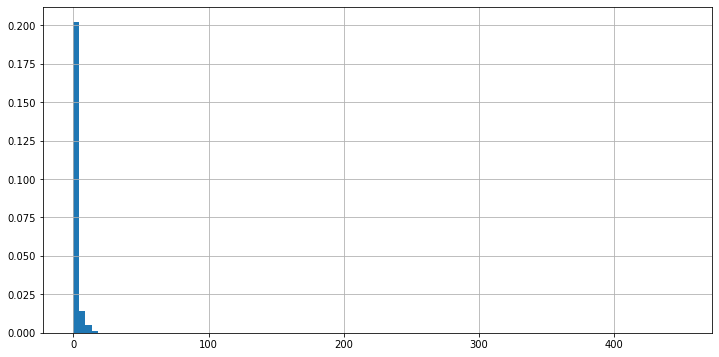

In [4]:
taxi_trips_2017.tip_amount.hist(bins=100, figsize=(12,6), density=True)

In [ ]:
# Firs of all, let's drop 0 values due to is interesting that our app suggests always a tip amount
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.tip_amount == 0].index)

# (A) Box-Cox transformation to reduce variance
boxcox_data,fitted_lambda = stats.boxcox(taxi_trips_2017['tip_amount'])
print("Resulting lambda Box-Cox is: ", fitted_lambda)
taxi_trips_2017['tip_amount_BOXCOX'] = boxcox_data

# (B) log transformation
taxi_trips_2017['tip_amount_LOG'] =  np.log(taxi_trips_2017['tip_amount'])

# Compare the data
# Plot the data before and after the transformations
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot2grid((2,3), (0,0), colspan=1)
ax2 = plt.subplot2grid((2,3), (0,1), colspan=1)
ax3 = plt.subplot2grid((2,3), (0,2), colspan=1)
ax4 = plt.subplot2grid((2,3), (1,0), colspan=3)
sns.distplot(taxi_trips_2017['tip_amount'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax1)
sns.distplot(taxi_trips_2017['tip_amount_BOXCOX'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax2)
sns.distplot(taxi_trips_2017['tip_amount_LOG'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax3);

taxi_trips_2017['tip_amount_BOXCOX'].plot(ax=ax4, c='indianred', label="Box-Cox")
taxi_trips_2017['tip_amount_LOG'].plot(ax=ax4, c='royalblue', label="Logarítmica")
ax4.set_ylim(0,20)
ax4.legend();

Resulting lambda Box-Cox is:  -0.00917977476125686


C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

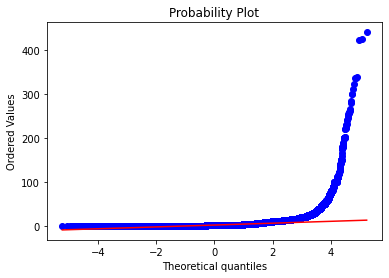

In [12]:
stats.probplot(taxi_trips_2017["tip_amount"],plot=pylab)
plt.show()

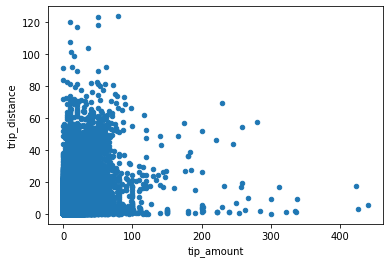

In [15]:
scatterplot(taxi_trips_2017, "tip_amount", "trip_distance")

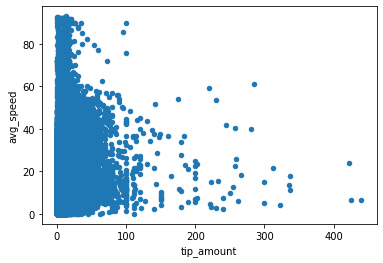

In [16]:
scatterplot(taxi_trips_2017, "tip_amount", "avg_speed")

There are high tip amount observations which are not following the crowd but it is not evidence to consider them as outliers

#### Model building <a id="model" ></a>

[Back to contents](#intro)

At this point, let's try some simple (with low number of parameters) regression models. In that sense, linear models are usually an option when the solution must be explained to third parts. Besides, if simple works..

In [27]:
X = taxi_trips_2017[['fare_amount', 'trip_distance', 'tolls_amount', 'RatecodeID',
               'avg_speed', 'weekday', 'hour']]
y = taxi_trips_2017['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

print('Loading: Lineear Regressor\n_____________________________________')

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

print('Loading: Ridge Regressor:\n_____________________________________')

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

print('Loading: Lasso Regressor\n_____________________________________')

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Loading: Lineear Regressor
_____________________________________


C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Test set evaluation:
_____________________________________
MAE: 0.5997290067435587
MSE: 2.1850883406856756
RMSE: 1.4782044312900957
R2 Square 0.7013617750050334
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5987178633331967
MSE: 2.075795976354776
RMSE: 1.4407622900238526
R2 Square 0.713164482117882
__________________________________
Loading: Ridge Regressor:
_____________________________________
Test set evaluation
_____________________________________
MAE: 0.5997284731534438
MSE: 2.1850882463494066
RMSE: 1.4782043993810214
R2 Square 0.7013617878980662
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5987173312349621
MSE: 2.0757959763852325
RMSE: 1.4407622900344221
R2 Square 0.7131644821136734
__________________________________


C:\Users\berta\AppData\Local\Temp\ipykernel_27488\882591338.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_df_2, ignore_index=True)


Loading: Lasso Regressor
_____________________________________
Test set evaluation:
_____________________________________
MAE: 0.596218149496008
MSE: 2.1936805391047214
RMSE: 1.481107875579872
R2 Square 0.7001874705904745
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5952154673618645
MSE: 2.0851993817876826
RMSE: 1.4440219464356083
R2 Square 0.7118651103598059
__________________________________


C:\Users\berta\AppData\Local\Temp\ipykernel_27488\882591338.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_df_2, ignore_index=True)


In [16]:
X = taxi_trips_2017[['fare_amount', 'trip_distance', 'tolls_amount', 'hour']]
y = taxi_trips_2017['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

print('Loading: Lineear Regressor\n_____________________________________')

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

print('Loading: Ridge Regressor:\n_____________________________________')

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

print('Loading: Lasso Regressor\n_____________________________________')

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Loading: Lineear Regressor
_____________________________________


C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Test set evaluation:
_____________________________________
MAE: 1.3302606014696865
MSE: 4.169663911178142
RMSE: 2.0419754923059537
R2 Square 0.3692252756522526
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.331163954782916
MSE: 4.138049678331819
RMSE: 2.0342196730765876
R2 Square 0.37047814835318604
__________________________________
Loading: Ridge Regressor:
_____________________________________
Test set evaluation
_____________________________________
MAE: 1.3302606090798106
MSE: 4.169663932310271
RMSE: 2.041975497480386
R2 Square 0.3692252724554451
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.3311639623005438
MSE: 4.138049678331919
RMSE: 2.0342196730766124
R2 Square 0.3704781483531707
__________________________________


C:\Users\berta\AppData\Local\Temp\ipykernel_20468\1553810047.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_df_2, ignore_index=True)


Loading: Lasso Regressor
_____________________________________
Test set evaluation:
_____________________________________
MAE: 1.3322454090802265
MSE: 4.178183260260091
RMSE: 2.044060483513169
R2 Square 0.3679364931068819
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.3331506824382884
MSE: 4.143761893055772
RMSE: 2.035623219816421
R2 Square 0.3696091486384516
__________________________________


C:\Users\berta\AppData\Local\Temp\ipykernel_20468\1553810047.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_df_2, ignore_index=True)


**Linear regressor** offers better results than the rest of models

I have tried simple models (with low number of parameters) in order to make a first approximation for predicting tip amounts. Regarding the results, the use of more variables returns better solutions (according to the R2 square).
In order to improve the model estimations, the are some possible solutions:

    1. Transforming input variables to set sronger relationships
    2. Training the model with a higher dataset
    3. Adding external data sources such as the weather, borought population or borought rent per capita.
    

#### Conclusions and final thoughts <a id="conc" ></a>

[Back to contents](#intro)

Next steps to complete the problem should be:
    
    1. Train new models in order to get more accurate predictions
    2. Transform the rest of variables for getting strong relationships among them
    3. Check the full-time availability of all input variables before the implementation. If not some options can be taken into a account:
        
        3.1. Stablish a default value for tips suggestion
        3.2. Develop a simple model based on always-available data (maybe related to the location) in order to suggest an accurate tip amount
        
    4. Having an API will be great in order to get the data in real-time but first some issues must be discussed:
        
        4.1. How fast does predict the model? Maybe, in super short trips async APIs do not work well. In that sense, the model must be able to predict in miliseconds to get an accurate system.
        4.2. What about non-availability of inputs? Right now, the model is not abe to deal with no entries so it must suggest a tip amount.
        4.3. Error management: related to the previous point, the API must offer a tip amount always, even if a terrible thing happens.